# Imports

In [ ]:
# import section
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import os
import copy
import time
import cv2


from google.colab import drive
from google.colab import files
from math import atan2, cos, sin, sqrt, pi, exp
from skimage import feature

# !pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17
!pip install matplotlib==3.3.4

# Mount Drive

In [ ]:
drive.mount("/content/drive", force_remount=True)
%ls
%cd '/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing'
%ls

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing
CV_assignment_ImageProcessing_2.pdf  exercise_13_no.ipynb
es10/                                instance_exercise1-7.ipynb
es11/                                plot1.png
es12/                                plot2.png
es13/                                plot.png
exercise_10.ipynb                    sample_image_fast.jpg
exercise_11.ipynb                    sample_image_harris.jpg
exercise_12.ipynb                    try1-7Exercise.ipynb
exercise_13.ipynb                    working_env_harris.jpg


# Load images



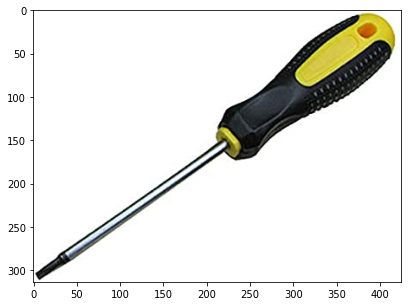

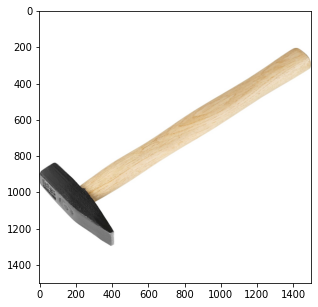

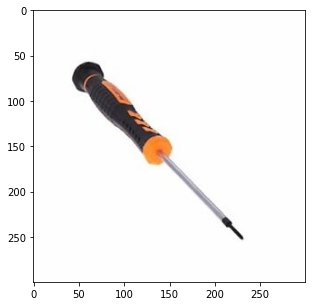

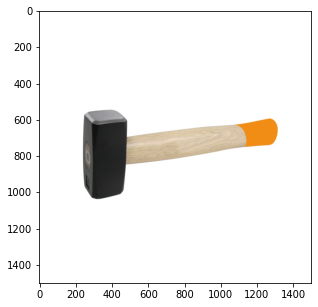

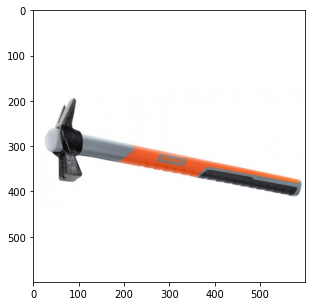

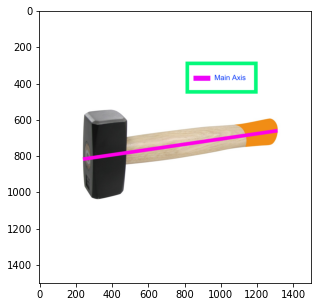

In [ ]:
def readImage(path, show_it = True, is_greyscale= True):
        img = cv2.imread(path)
        # img = cv2.resize(img,(800,600)) # 4:3
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if is_greyscale:
          img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        if show_it:
            fig,ax = plt.subplots(figsize=(15, 5))
            ax.imshow(img, cmap=plt.cm.gray)
        return img

def getFiles(path, show_it = True, is_greyscale= True):
    images = []
    for file in os.listdir(path):
      if (file != "final_result.png"):
        images.append(readImage(path+'/' + file, show_it, is_greyscale=is_greyscale))
    return images

images_rgb = getFiles("./es13", is_greyscale = False)
images_bw = getFiles("./es13",show_it = False)
desired_result = readImage("./es13/final_result.png", is_greyscale= False)

r2d = 180/np.pi

# Compute binary images

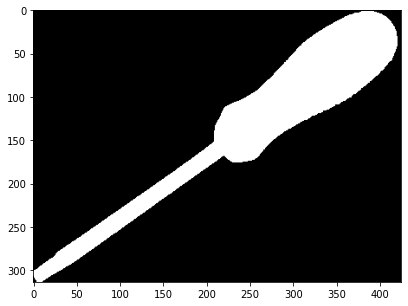

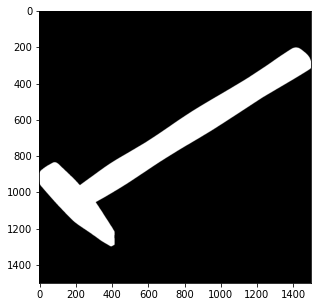

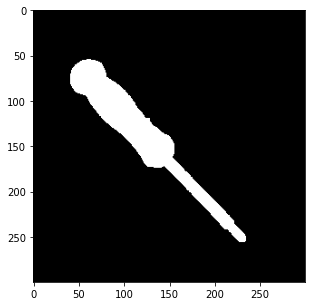

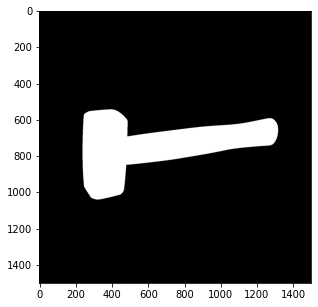

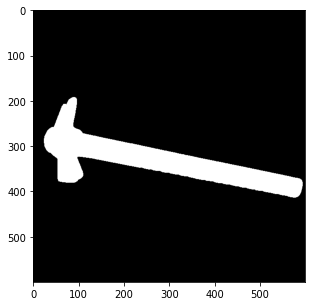

In [ ]:
binary_images = []
for img in images_bw:
  rets,threshs = cv2.threshold(img,230,255,cv2.THRESH_BINARY_INV)
  binary_images.append(threshs)

# adjust the screewdriver binary image, fllling holes and connecting edges with dilation
footprint = np.ones((5, 5))
binary_images = [cv2.dilate(img, footprint) for img in binary_images]             

for i,img  in enumerate(binary_images):
    fig,ax = plt.subplots(figsize=(15, 5))
    ax.imshow(img, cmap=plt.cm.gray)
plt.show()

# Analysis in frequency and filtering

# Pre-processing table and functions

In [ ]:
preProcessing_table = [
  { 'filter':'laplacian' , 'displacement_y': False , 'use_binary':True  },
  { 'filter':'sobel_y'   , 'displacement_y': True  , 'use_binary':False },
  { 'filter':'sobel_x'   , 'displacement_y': True  , 'use_binary':True  },
  { 'filter':'sobel_y'   , 'displacement_y':False  , 'use_binary':True  },
  { 'filter':'sobel_y'   , 'displacement_y':True   , 'use_binary':True  }
]

# Filters in frequency
def distance(point1,point2):
    return sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def gaussianHP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1 - exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base  

# displacement computation

def estimate_displacementBinary(image,width,height):
    displacement_image = 0
    start_point = 0
    end_point = 0
    for i in range(int(height)):
      if i>=int(height/2) and start_point==0:
        displacement_image += 1

      if start_point==0:
        if image[i][int(width/2)] == 255: 
          start_point = i
      else:
        if image[i][int(width/2)] == 0: 
          end_point = i

      if end_point != 0:
        return (end_point-start_point)/2 + displacement_image
        
    return 0

def estimate_displacementBW(image,width,height):
    displacement_image = 0
    start_point = 0
    end_point = 0

    for i in range(int(height)):
      if i>=int(height/2) and start_point==0:
        displacement_image += 1

      if start_point==0:
        if image[i][int(width/2)] < 253: 
          start_point = i
      else:
        if image[i][int(width/2)] == 255:
          end_point = i

      if end_point != 0:
        val = (end_point-start_point)/2 + displacement_image
        if image[int(height/2 +val)][int(width/2)] == 255:
          return - val
        else:
          return val
    return 0

Applied Laplacian


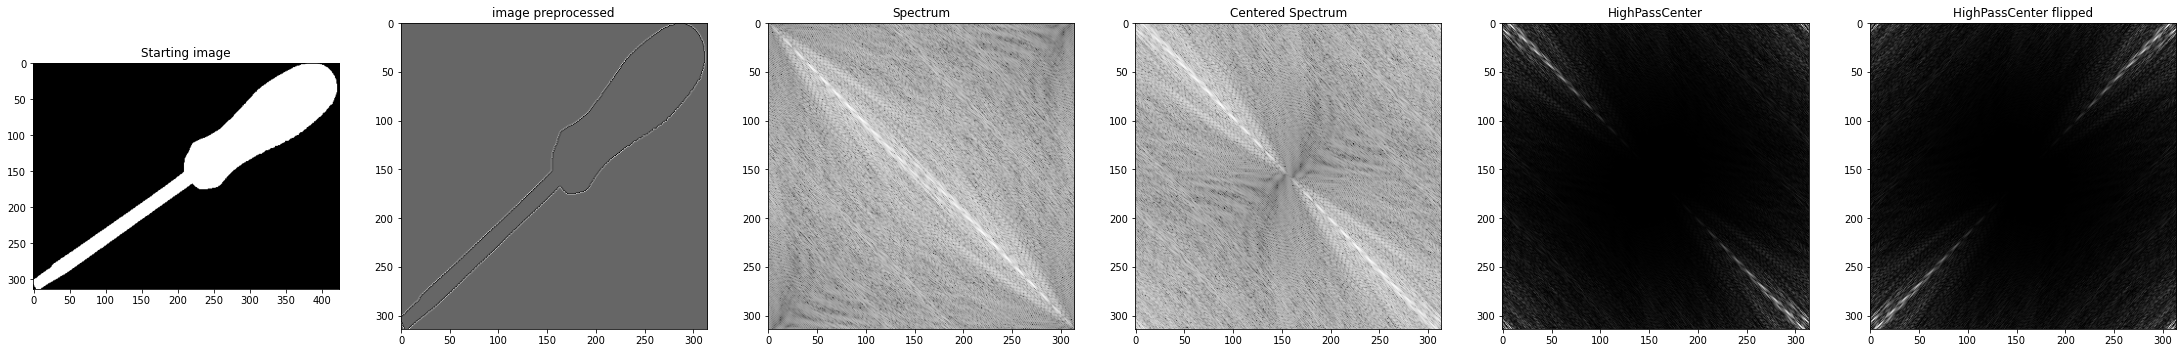

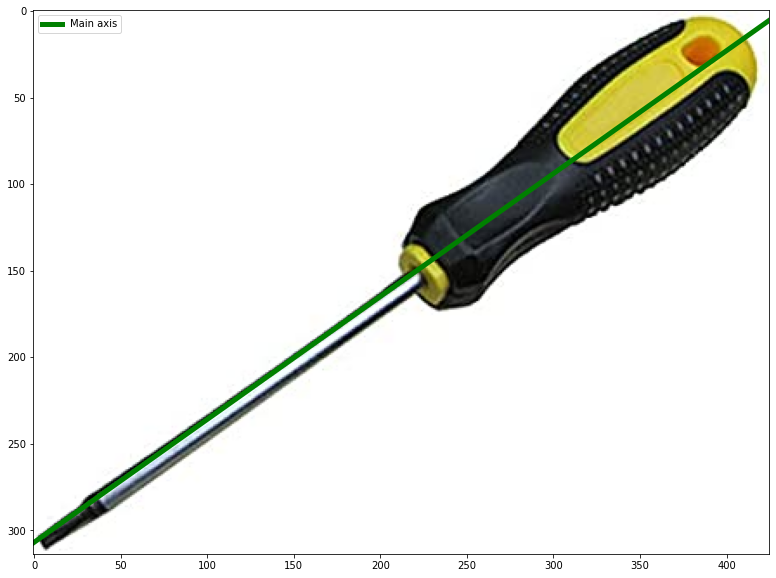

Applied sobel y


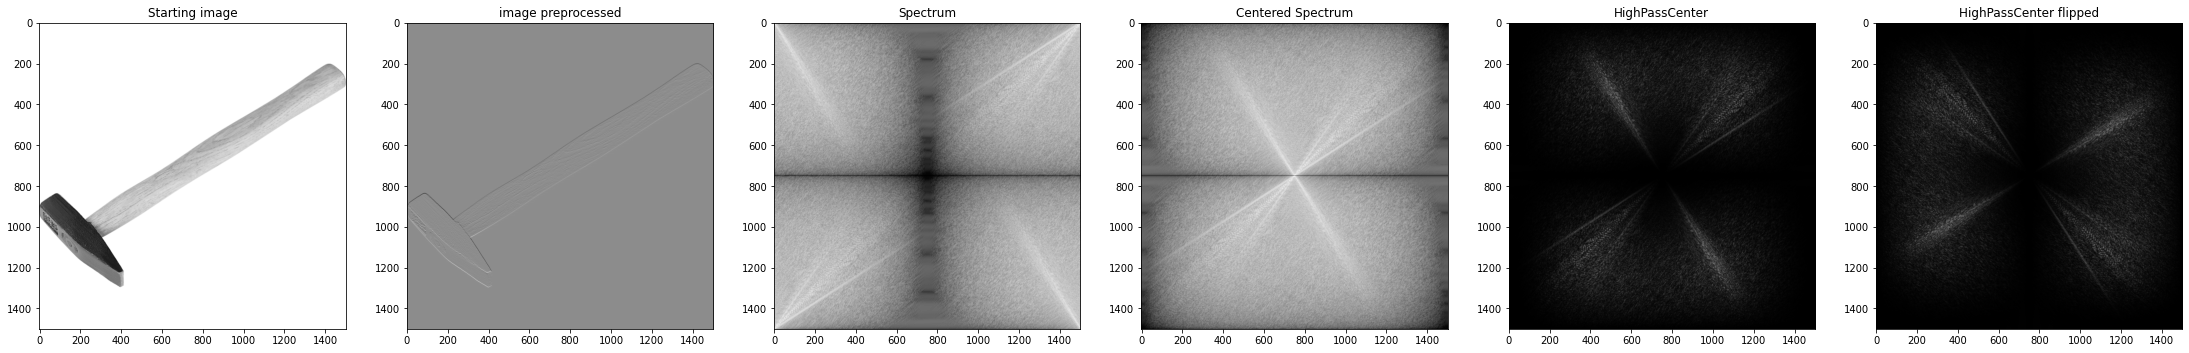

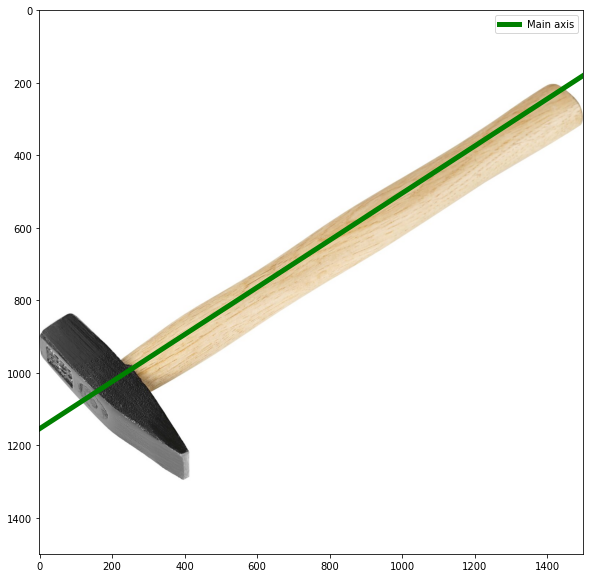

Applied sobel x


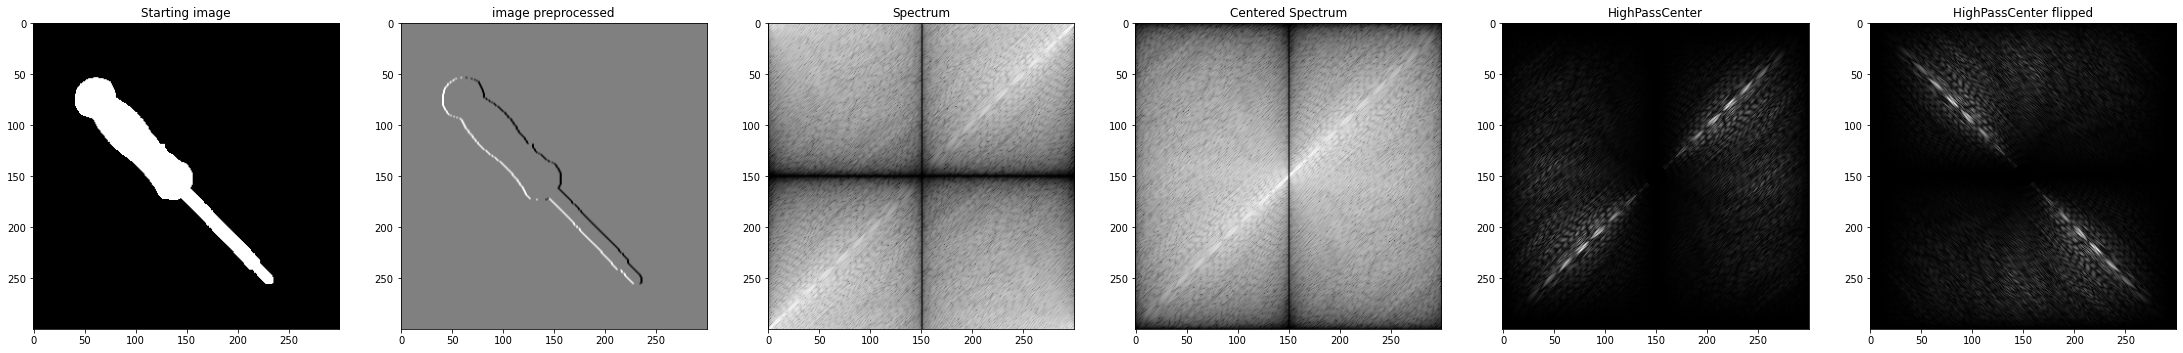

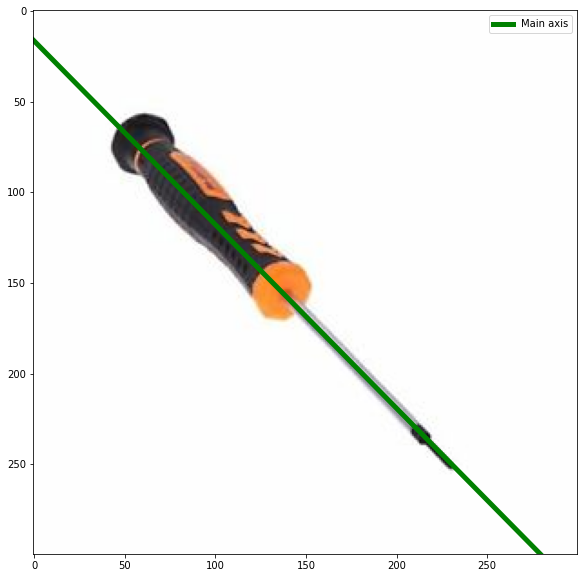

Applied sobel y


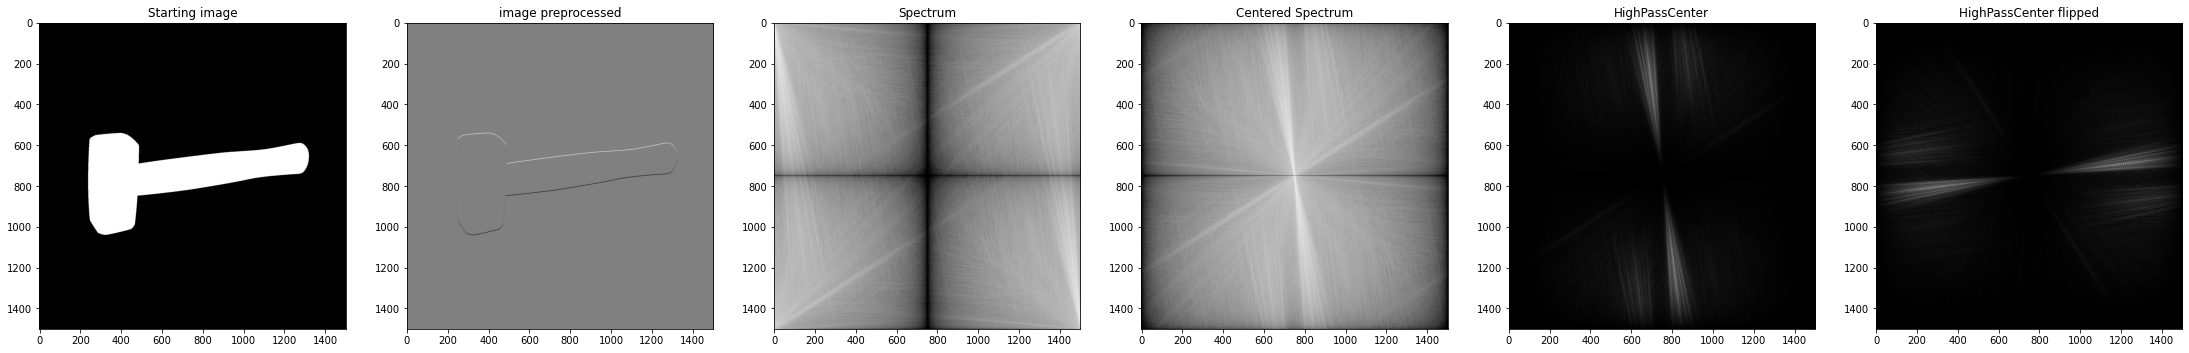

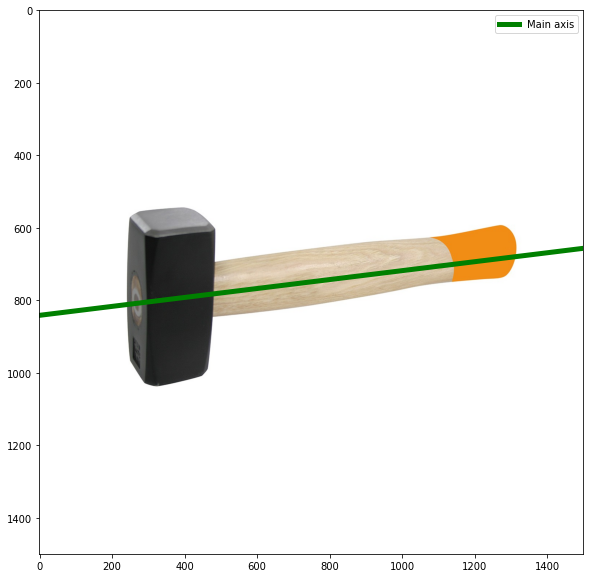

Applied sobel y


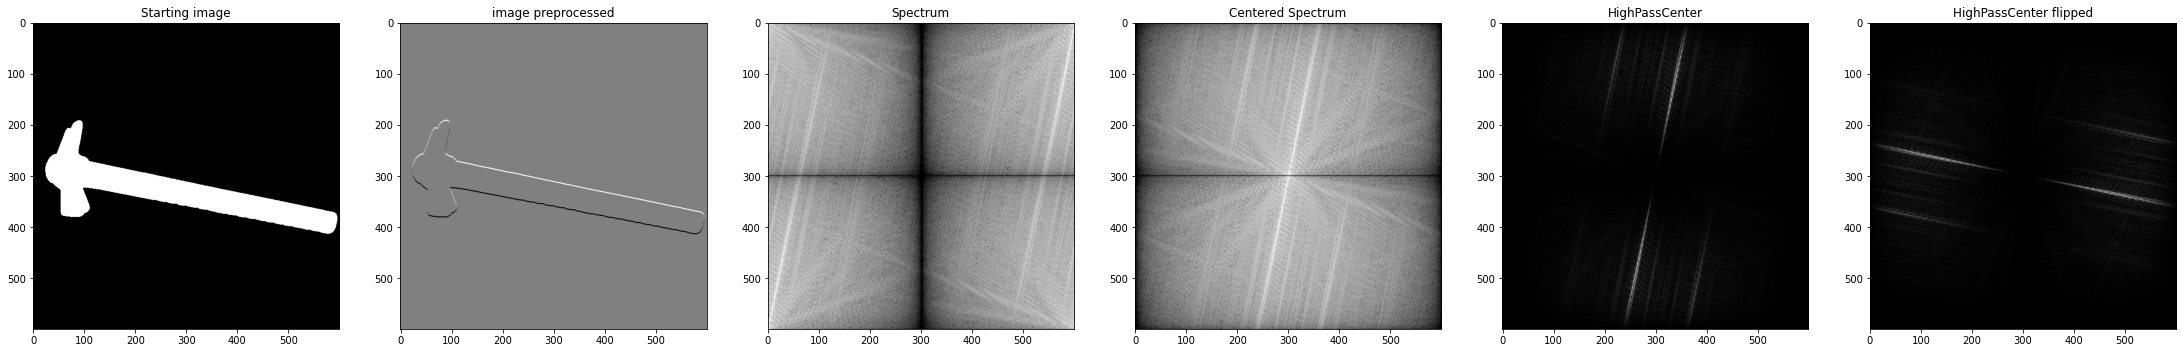

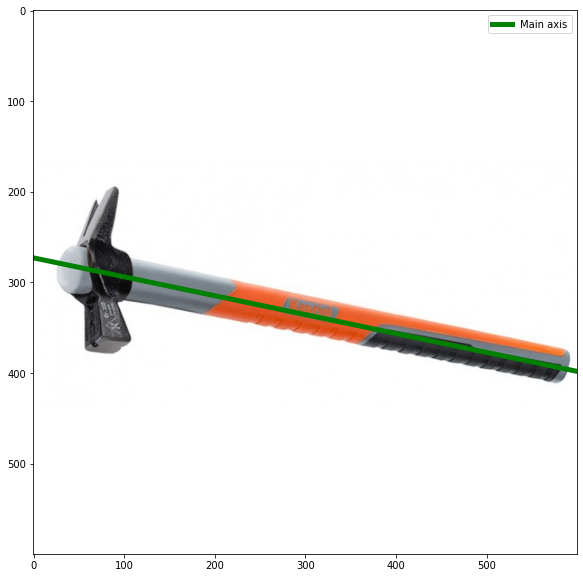

In [ ]:
# loop over the images
for num_img in range(5):

  plt.figure(figsize=(6.4*6, 4.8*6), constrained_layout=False)

  # open the image in bw or binary
  if preProcessing_table[num_img]['use_binary']:
    img = binary_images[num_img]
  else:
    img = images_bw[num_img]

  plt.subplot(161), plt.imshow(img, "gray"), plt.title("Starting image")

  # shape properties
  width = img.shape[1]
  height = img.shape[0]
  is_squared = width == height

  # work with squared image, then trasnform back
  if not(is_squared):
    img = cv2.resize(img,(height,height))

  # estimate displacement from the center

  if preProcessing_table[num_img]['displacement_y'] and preProcessing_table[num_img]['use_binary']:
    displacement_y = estimate_displacementBinary(img,width,height)
  elif preProcessing_table[num_img]['displacement_y'] and not(preProcessing_table[num_img]['use_binary']):
    displacement_y = estimate_displacementBW(img,width,height)

  # apply derivative filters

  if preProcessing_table[num_img]['filter']== 'sobel_x':
    print("Applied sobel x")
    img = cv2.Sobel(img,cv2.CV_64F,1,0) # horizontal sobel

  elif preProcessing_table[num_img]['filter']== 'sobel_y':
    print("Applied sobel y")
    img = cv2.Sobel(img,cv2.CV_64F,0,1) # vertical sobel

  elif preProcessing_table[num_img]['filter']== 'sobel_magn':
    print("Applied sobel magnitude")
    sobelx_img = cv2.Sobel(img,cv2.CV_64F,1,0) # horizontal sobel
    sobely_img = cv2.Sobel(img,cv2.CV_64F,0,1) # vertical sobel
    img = np.hypot(sobelx_img,sobely_img)  # magnitude

  elif preProcessing_table[num_img]['filter']== 'laplacian':
    print("Applied Laplacian")
    img = cv2.Laplacian(img,cv2.CV_64F)

  plt.subplot(162), plt.imshow(img, "gray"), plt.title("image preprocessed")


  # Transform the image in frequency using Fourier Transform

  original = np.fft.fft2(img)
  plt.subplot(163), plt.imshow(np.log(1+np.abs(original)), "gray"), plt.title("Spectrum")

  # centre frequencies

  center = np.fft.fftshift(original)
  plt.subplot(164), plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Centered Spectrum")

  # filter the image using Gaussian HP filter in frequency

  HighPassCenter = center * gaussianHP(1000000000,img.shape) # 1000000000
  plt.subplot(165), plt.imshow(np.log(1+np.abs(HighPassCenter)), "gray"), plt.title("HighPassCenter")

  # flip it

  if is_squared:
    flipped =cv2.transpose(np.log(1+np.abs(HighPassCenter)))
    flipped = np.flip(flipped, axis=0)
  else:
    flipped = np.flip( np.log(1+np.abs(HighPassCenter)), axis=0 )


  plt.subplot(166), plt.imshow(flipped, "gray"), plt.title("HighPassCenter flipped")

  # take max from flipped
  max_img = flipped.max()

  # i take the 2 coordinates at maximum value to draw a line
  result = np.where(flipped == max_img)

  # first point
  x1,y1 = result[1][0],result[0][0]

  # second point
  x2,y2 = result[1][1],result[0][1]

  # take the original image to draw in
  original_image = images_rgb[num_img]

  # print lines adding displacement if necessary
  plt.show()

  fig,ax = plt.subplots(figsize=(15, 10))

  if preProcessing_table[num_img]['displacement_y']:
    ax.axline((x1,y1+displacement_y), (x2,y2+displacement_y), color='green', linewidth = 5, label='Main axis', figure = fig)
  else:
    ax.axline((x1*width/height,y1), (x2*width/height,y2), color='green', linewidth = 5,label='Main axis', figure = fig)

  ax.legend()
  plt.imshow(original_image)
  plt.show()